# Link prediction with Neo4j and a single metric

This notebook runs a link prediction model from a Neo4j graph using link prediction functions from the GDS.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from neo4j import GraphDatabase

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

Using TensorFlow backend.


In [2]:
SEED = 12345

## Extracting data from Neo4j

The Cypher query computing link prediction score for each pair of nodes in the graph can take some time. If you encounter issues in running it, you can use the extracted data in [`../data/adamic_adar_scores_labelled.csv`](`../data/adamic_adar_scores_labelled.csv`)

In [3]:
cypher = """
MATCH (u)
MATCH (v) 
WHERE u.id < v.id  // exclude u = v
AND NOT ( (u)-[:KNOWS_TRAIN]-(v) )
WITH u, v,  gds.alpha.linkprediction.adamicAdar(
                u, v, {
                        relationshipQuery: "KNOWS_T1", 
                        direction: "BOTH"
                }
            ) as score
RETURN  u.id as u_id, 
        v.id as v_id, 
        score, 
        EXISTS( (u)-[:KNOWS_T2]-(v) ) as label
"""

In [4]:
# Set your own connection parameters
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "admin"))

In [5]:
with driver.session() as session:
    rec = session.run(cypher)
    d = rec.data()

In [6]:
df = pd.DataFrame.from_records(d)
# df.to_csv("adamic_adar_scores_labelled.csv", index=False)

In [7]:
# cached version of the above dataset
# df = pd.read_csv("../data/adamic_adar_scores_labelled.csv")

In [8]:
df.head()

,u_id,v_id,score,label
0,0,1,4.804306,True
1,0,2,0.000000,False
2,0,3,1.880866,False
3,0,4,8.771774,False
4,0,5,4.732224,False


In [9]:
df.label.value_counts()

False    105555
True      19195
Name: label, dtype: int64

## Creating train/test samples with undersampling

In [10]:
X = df[["score"]]
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
rus = RandomUnderSampler(random_state=SEED)
X_train, y_train = rus.fit_resample(X_train, y_train)

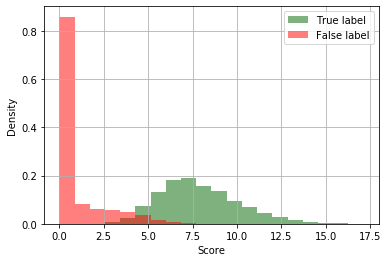

In [12]:
plt.hist(
    X_train[y_train == True].score,
    range=(0, max(df.score)),
    bins=20,
    alpha=0.5,
    density=True,
    label="True label",
    color="darkgreen"
)
plt.hist(
    X_train[y_train == False].score,
    range=(0, max(df.score)),
    bins=20,
    alpha=0.5,
    density=True,
    label="False label",
    color="red"
)
plt.grid()
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.show()

## Drawing the ROC and precision-recall cruves

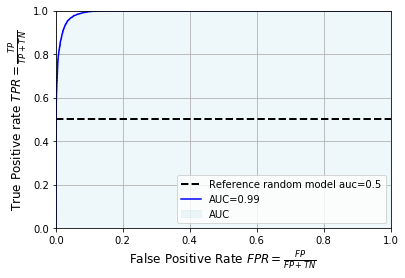

In [13]:
fpr, tpr, _thresholds = roc_curve(y_train, X_train.score)

auc_score = auc(fpr, tpr)

# plt.plot(fpr, tpr, color='red', linewidth=2, label='Score (auc=%0.2f)' % auc_score)
plt.plot([0, 1], [0.5, 0.5], color='black', linewidth=2, linestyle='--', label="Reference random model auc=0.5")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel(r"True Positive rate $TPR=\frac{TP}{TP+TN}$", fontsize=12)
plt.xlabel(r"False Positive Rate $FPR=\frac{FP}{FP+TN}$", fontsize=12)

plt.fill_between(fpr, 0, tpr, alpha=0.2, label="AUC", color="lightblue")
plt.plot(fpr, tpr, "blue", label=f"AUC={auc_score:2.2f}")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.legend(loc="lower right", fontsize=10)
plt.show()

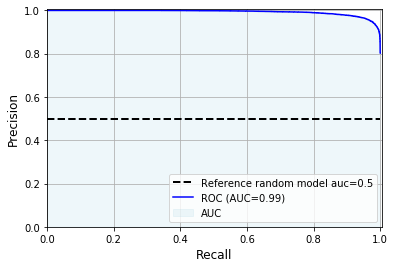

In [14]:
precisions, recalls, thresholds = precision_recall_curve(y_train, X_train.score)

auc_score = auc(recalls, precisions)

# plt.plot(fpr, tpr, color='red', linewidth=2, label='Score (auc=%0.2f)' % auc_score)
plt.plot([0, 1], [0.5, 0.5], color='black', linewidth=2, linestyle='--', label="Reference random model auc=0.5")
plt.xlim([0.0, 1.005])
plt.ylim([0.0, 1.005])
plt.xlabel(r"Recall", fontsize=12)
plt.ylabel(r"Precision", fontsize=12)

plt.fill_between(recalls, 0, precisions, alpha=0.2, label="AUC", color="lightblue")
plt.plot(recalls, precisions, "blue", label=f"ROC (AUC={auc_score:2.2f})")

plt.grid()
plt.legend(loc="lower right", fontsize=10)
plt.show()

## Choosing a score threshold

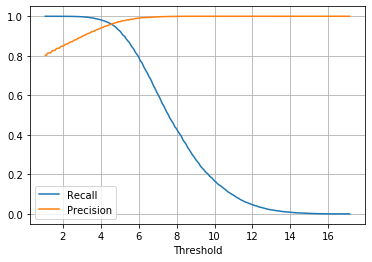

In [15]:
# precisions, recalls, thresholds = precision_recall_curve(y_train, X_train.score)
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.legend()
plt.grid()
plt.xlabel("Threshold")
plt.show()

## Building model and measuring performances

In [16]:
class SimpleModel(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold):
        self.threshold = threshold
    def fit(self, X, y):
        self.classes_ = [True, False]
        return self
    def predict(self, X, y=None):
        return X > self.threshold

In [17]:
model = SimpleModel(threshold=5)
model.fit(X_train, y_train)
pred = model.predict(X_test)

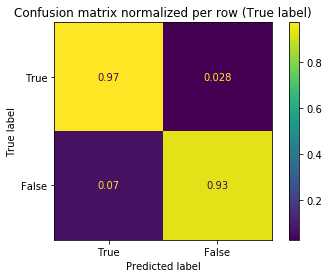

In [18]:
plot_confusion_matrix(model, X_test, y_test, normalize="true")
plt.title("Confusion matrix normalized per row (True label)")
plt.show()

In [19]:
X_test

,score
71010,0.678427
112460,0.000000
106798,0.000000
29591,0.000000
60298,0.000000
...,...
89753,6.338540
77861,0.000000
61758,0.000000
102523,0.000000


## Saving the results into Neo4j

In [20]:
df_test = df.loc[X_test.index]
df_test["score"] = pred
df_test.head()

,u_id,v_id,score,label
71010,171,388,False,False
112460,342,456,False,False
106798,310,314,False,False
29591,63,171,False,False
60298,140,309,False,False


In [23]:
cypher = """
MATCH (u:Node {id: $u_id})
MATCH (v:Node {id: $v_id})
MERGE (u)-[r:FUTURE_KNOW]->(v)
ON CREATE SET r.score = $score
"""

with driver.session() as session:
    for t in df_test.itertuples():
        if t.label:
            session.run(cypher, parameters={
                "u_id": t.u_id,
                "v_id": t.v_id,
                "score": t.score
            })

In [24]:
sum(df_test.label)

3839